<a href="https://colab.research.google.com/github/werlang/emolearn-ml-model/blob/main/conv3d_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.engine import  Model
from keras.models import Sequential, load_model
from keras.layers import TimeDistributed, GRU, LSTM, Dropout, Conv2D, Conv3D, BatchNormalization, MaxPooling2D, MaxPooling3D, Flatten, Dense, Input, Add, Activation, AveragePooling3D, Bidirectional
from keras.utils import Sequence, plot_model, to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, Callback, ModelCheckpoint
from keras.metrics import AUC
from keras.regularizers import l2
import pandas as pd
import numpy as np
import os, cv2
import datetime
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from keras import backend as K
import math
from IPython.display import Image
from numba import cuda
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy=0.6666)
# X, y = sm.fit_resample(X, y)

def restart():
    cuda.select_device(0)
    cuda.close()


def start_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !pip install Keras-Applications


def extract_data():
    !mkdir features

    # aligned faces extracted from openface
    print("COPYING TRAIN SET...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/daisee_aligned/Train_112.zip" -d features 
    print("COPYING VALIDATION SET...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/daisee_aligned/Validation_112.zip" -d features 
    print("COPYING TEST SET...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/daisee_aligned/Test_112.zip" -d features 
    print("COPYING LABELS...")
    !cp -r "drive/My Drive/Doutorado/Implementação/labels" ./
    print("DONE")


class Generator_V(Sequence):
    def __init__(self, split, batch_size, frames, pre_proc):
        self.batch_size = batch_size 
        self.split = split
        self.labels, self.videos = [], []

        print("Building {} generator...".format(split))
        csv_path = "{}/{}Labels.csv".format(labels_path, split)
        csv = pd.read_csv(csv_path)
        Y = to_categorical(np.array(csv[emotion])//2, 2)
        clips = csv['ClipID']
            
        fps = 15
        skip = int(round(interval * fps / frames, 0))

        for Yi in range(len(clips)):
            file_name = clips[Yi].split(".")[0]
            subject = file_name[:6]
            dir_path = "{}/{}/{}/{}_aligned".format(features_path, self.split, subject, file_name)
            files = []
            for i in range(1,350):
                image_path = "{}/frame_det_00_000{:03d}.jpg".format(dir_path, i)
                if os.path.isfile(image_path):
                    files.append(image_path)
            
            # ignore more than 150 files
            if len(files) != 150:
                print(len(files), files)

            # files = files[:150]
            # if len(files) < 150:
            #     for i in range(150 - len(files)):
            #         files.append(files[-1])

            for i in range(0, (len(files) - frames*skip) // skip + 1, np.max([1, int(stride * frames)])):
                temp = []
                for j in range(i*skip, (i+frames)*skip, skip):
                    temp.append(files[j])
                self.videos.append(temp)
                self.labels.append(Y[Yi])

        if pre_proc:
            Y = np.array(self.labels)
            # majority group ratio after undesampling
            us_size = 0.8
            while sum(Y[:,1]) / len(Y) > us_size:
                n = np.random.randint(0,len(Y))
                if Y[n,1] == 1:
                    self.videos.pop(n)
                    self.labels.pop(n)
                    Y = np.array(self.labels)

            # minority group ratio after oversampling
            os_size = 0.4
            while sum(Y[:,0]) / len(Y) < os_size:
                n = np.random.randint(0,len(Y))
                if Y[n,0] == 1:
                    i = np.random.randint(0,len(Y))
                    self.videos.insert(i, self.videos[n])
                    self.labels.insert(i, self.labels[n])
                    Y = np.array(self.labels)


        print("0: {} ({:.2f}), 1: {} ({:.2f})".format(sum(Y[:,0]), sum(Y[:,0]) / len(Y) * 100, sum(Y[:,1]), sum(Y[:,1]) / len(Y) * 100))
        np.save("{}/{}.npy".format(labels_path, split), self.labels)
        print("Done")


    def __len__(self):
        return int(np.ceil(len(self.videos) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.videos[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        # print(batch_x)
        videos = []
        for video in batch_x:
            images = []
            for name in video:
                img = cv2.imread(name, 0)
                # img = img[:,:,0].reshape((img.shape[0], img.shape[1], 1))
                images.append(img)
            videos.append(np.array(images)/255)
            
        videos = np.array(videos)
        label = np.array(batch_y)

        return videos, label


def avgacc(y_true, y_pred):
    def get_class_acc(id):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        # Replace class_id_preds with class_id_true for recall here
        accuracy_mask = K.cast(K.equal(class_id_pred, id), 'int32')
        class_acc_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * accuracy_mask
        class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
        return class_acc

    return sum([get_class_acc(0), get_class_acc(1)]) / 2


def build_model():
    print("Building model...")
    ########### IF BUILT, MUST DEFINE A NAME TO APPEND TO DIRECTORY NAME ###############
    global ident_name

    ########### IF LOADED, MUST DEFINE DIR NAME AND STARTING EPOCH ############
    global dir_name

    def residual_block(input, output_size):
        KR = None
        input_size = input.shape[-1]
        
        s = 1 if input_size == output_size else 2
        x = Conv3D(output_size//4, strides=s, kernel_regularizer=KR, kernel_size=1, padding='valid')(input)
        x = BatchNormalization()(x)
        x = Activation(act_func)(x)

        x = Conv3D(output_size//4, strides=1, kernel_regularizer=KR, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(act_func)(x)

        x = Conv3D(output_size, strides=1, kernel_regularizer=KR, kernel_size=1, padding='valid')(x)
        x = BatchNormalization()(x)

        if input_size == output_size:
            shortcut = input
        else:
            shortcut = Conv3D(output_size, strides=2, kernel_regularizer=KR, kernel_size=1, padding='valid')(input)
            shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        x = Activation(act_func)(x)

        return x

    KR = l2(1e-2)
    # KR = None
    act_func = 'relu'
    filters = 16

    input = Input(shape=(time_frames,112,112,1))
    x = Conv3D(filters, kernel_regularizer=KR, kernel_size=3)(input)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    blocks = [3, 4, 6, 3]
    for b in blocks:
        filters = filters * 2
        for i in range(b):
            x = residual_block(x, filters)

    x = AveragePooling3D(pool_size=(2, 2, 2))(x)
    x = Flatten()(x)

    x = Dense(256, kernel_regularizer=KR, activation=act_func)(x)
    x = Dropout(0.6)(x)
    x = Dense(128, kernel_regularizer=KR, activation=act_func)(x)
    x = Dropout(0.6)(x)
    x = Dense(64, kernel_regularizer=KR, activation=act_func)(x)
    x = Dropout(0.6)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input, x)

    model.compile(
        loss='categorical_crossentropy',
        # optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9), 
        optimizer = Adam(lr=1e-3),
        metrics=[avgacc,'accuracy'])

    plot_model(model, show_layer_names=False, show_shapes=True)

    loadModel = False if epoch == 0 else True

    if not loadModel:
        t = datetime.datetime.now()
        prefix = str(t.year) +'-'+ str(t.month) +'-'+ str(t.day) +'-'+ str(t.hour) +'-'+ str(t.minute) +'-'+ str(t.second)
        save_dir = "{}/{}-{}".format(drive_save_path, prefix, ident_name)
        os.mkdir(save_dir)
    else:
        file_name = "{:03d}.h5".format(epoch)
        save_dir = "{}/{}".format(drive_save_path, dir_name)
        print("Loading model from {}/{}.".format(save_dir, file_name))
        model = load_model("{}/{}".format(save_dir, file_name), custom_objects={'avgacc': avgacc})

    return model, save_dir, epoch


def set_callbacks():
    #callbacks
    checkpoint = ModelCheckpoint(
        filepath = save_dir + '/{epoch:03d}.h5', 
        monitor = 'val_loss', 
        verbose=1, 
        save_best_only=True,
    )

    tensorboard = TensorBoard(
    	log_dir         = "{}/logs".format(save_dir),
    	histogram_freq  = 0,
    	write_graph     = True,
    	write_grads     = False,
    	write_images    = True
    )

    early_stop = EarlyStopping(
        monitor 	= 'val_loss',
        patience 	= 10,
        restore_best_weights = True,
        verbose     = 1,
        min_delta   = 1e-5
    )

    reduce_lr_plateau = ReduceLROnPlateau(
        monitor 	= 'val_loss',
        factor		= 0.2,
        patience	= 5,
        min_lr		= 1e-6,
        verbose     = 1
    )

    return [checkpoint, early_stop, reduce_lr_plateau]


def fit_model(train_weights):
    #calculate weights based on train set distribution
    label_array = np.load("{}/Train.npy".format(labels_path))
    weights = {0: 1, 1: 1}
    if train_weights != [1,1]:
        weights = {0: train_weights[0], 1: train_weights[1]}
        print("Train weights: {}".format(weights))

    def run():
        #run the model
        return model.fit(
            gen_train,
            epochs = 1000,
            validation_data = gen_val,
            # class_weight = weights,
            callbacks = callbacks,
            initial_epoch = epoch)
        
    hist = run()  

    plt.plot(hist.history['loss'], '#0000ff', label="loss")
    plt.plot(hist.history['val_loss'], '#ff0000', label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(hist.history['loss'], '#0000ff', label="loss")
    plt.plot(hist.history['val_loss'], '#ff0000', label="val_loss")
    plt.axis([5, None, 0, None])
    plt.legend()
    plt.show()

    plt.plot(hist.history['avgacc'], '#0000ff', label="avgacc")
    plt.plot(hist.history['val_avgacc'], '#ff0000', label="val_avgacc")
    plt.plot(hist.history['accuracy'], '#0055aa', label="acc")
    plt.plot(hist.history['val_accuracy'], '#aa5500', label="val_acc")
    plt.legend()
    plt.show()


def predict(**kw):
    global gen_test
    try:
        gen_test
    except:
        gen_test = Generator_OF("Test", batch_size, False)
    
    if (kw and kw['force']):
        gen_test = Generator_OF("Test", batch_size, False)

    Y_true = np.load("{}/Test.npy".format(labels_path)).argmax(axis=1)

    print("Predicting...")
    Y_pred = (model.predict(gen_test, verbose=1)).argmax(axis=1)
    print("\nConfusion matrix:")
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)

    print("\nEvaluating...")
    ev = model.evaluate(gen_test, verbose=1)
    # print("Loss: {}, Acc: {}".format(ev[0], ev[1]))

    hits = [0,0]    
    for i in range(len(Y_true)):
        if (Y_true[i] == 0 and Y_pred[i] == 0):
            hits[0] = hits[0] + 1
        if (Y_true[i] == 1 and Y_pred[i] == 1):
            hits[1] = hits[1] + 1

    hits[0] = hits[0] / (len(Y_true) - sum(Y_true))
    hits[1] = hits[1] / sum(Y_true)
    print("\nPer class accuracy:\n0: {}\n1: {}".format(hits[0], hits[1]))
    print("Average class accuracy: {}".format(sum(hits) / len(hits)))
    return gen_test
        

Building Train generator...
0: 659.0 (40.01), 1: 988.0 (59.99)
Done
Building Validation generator...
0: 166.0 (11.62), 1: 1263.0 (88.38)
Done
Building model...
Epoch 1/1000
52/52 [==============================] - ETA: 0s - loss: 6.6262 - avgacc: 0.5145 - accuracy: 0.5288
Epoch 00001: val_loss improved from inf to 4.92575, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2020-10-21-21-9-36-conv3d-true-resnet-112px-1c/001.h5
52/52 [==============================] - 42s 804ms/step - loss: 6.6262 - avgacc: 0.5145 - accuracy: 0.5288 - val_loss: 4.9257 - val_avgacc: 0.4424 - val_accuracy: 0.8838
Epoch 2/1000
52/52 [==============================] - ETA: 0s - loss: 4.5365 - avgacc: 0.5298 - accuracy: 0.5574
Epoch 00002: val_loss improved from 4.92575 to 3.81211, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2020-10-21-21-9-36-conv3d-true-resnet-112px-1c/002.h5
52/52 [==============================] - 34s 663ms/step - loss: 4.5365 - avgacc: 0.5298 - accuracy: 0.5574 - val_loss: 3.8

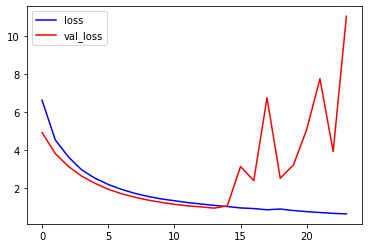

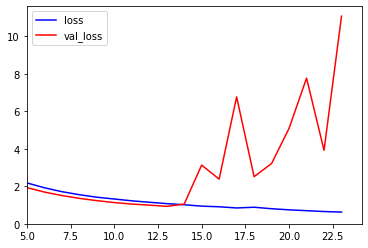

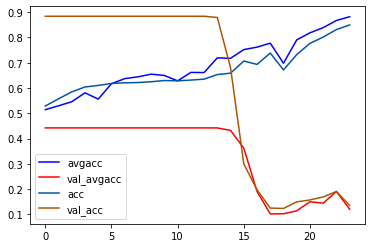

In [ ]:
emotion = "Engagement"
labels_path = "labels"
features_path = "features"
drive_save_path = 'drive/My Drive/1NOSYNC/DT/checkpoint'
ident_name = 'conv3d-true-resnet-112px-1c'
dir_name = '2020-10-9-22-54-29-openface-daisee-avgacc'
batch_size = 32
time_frames = 50
interval = 5
stride = 1
epoch = 0

# restart()
# start_colab()
# extract_data()

gen_train = Generator_V('Train', batch_size, time_frames, True)
gen_val = Generator_V('Validation', batch_size, time_frames, False)
model, save_dir, epoch = build_model()
callbacks = set_callbacks()
fit_model([1,1])

# gen_test = Generator_V('Test', batch_size, time_frames, False)
# gen_test = predict()

# Image('model.png')
# model.summary()